# Setup

In [29]:
#load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import glob
import csv

#get area
from glambie.const import regions, constants
from glambie.util import mass_height_conversions as mhc
from glambie.data.timeseries import Timeseries
from glambie.processing import processing_helpers as proc
#import urllib.request as url

#TO DO:
#do regional hydrological years

In [30]:
#set local path to 
local_path = 'C:/Users/Milva/glambie/glambie/output_plots/'
os.chdir(local_path)

#set output folder name
folder_name = 'final_squared_area_2023_2026-02-10_19-30'

#set RGI variable
rgi = 6

#start_date that you want the lines to meet + 0.5
#2023.5 for meets at end & 2012 for meets halfway
end_year = 2012.5 #2023.5

# function

In [31]:
def get_adjusted_area2(
        self, start_date: float, end_date: float, rgi_area_version: int
    ) -> float:
        """
        Calculates the area of a region adjusted with the area change to the given time period

        Parameters
        ----------
        start_date : float
            start date of time period to be considered
        end_date : float
            end date of time period to be considered
        rgi_area_version : int, optional
            version of RGI area, currently implemented are 5, 6 and 7

        Returns
        -------
        float
            adjusted area to time period given in km2
        """
        time_period_mean = (start_date + end_date) / 2
        static_area = getattr(self, "rgi{}_area".format(str(rgi_area_version)))

        start_year = 2000.5
        #end_year = 2023.5 #this one we have to change to make sure that it overlaps: 2023.5 for meets at end & 2012.5 for meets halfway
    
        area_change = (self.area_change / 100)
        c = (area_change * static_area)/23 #makes sure that the area can't increase for between 2000 and 2023
    
        adjusted_area = (
            static_area
            + (time_period_mean - self.area_change_reference_year)
            * (self.area_change / 100)
            * static_area
            + c * (time_period_mean - start_year)*(time_period_mean - end_year)
        )
        return adjusted_area

# Input and output directory

In [32]:
#set input and output directories
data_directory = os.path.join(local_path, 'processing/', folder_name)

#get a list of all the regions/folders excluding global
list_of_folders = sorted(os.listdir(data_directory)[1:20])

#directory global
global_dir = os.path.join(data_directory + '/', '0_global/consensus/csvs')

list_of_folders
#global_dir

['10_north_asia',
 '11_central_europe',
 '12_caucasus_middle_east',
 '13_central_asia',
 '14_south_asia_west',
 '15_south_asia_east',
 '16_low_latitudes',
 '17_southern_andes',
 '18_new_zealand',
 '19_antarctic_and_subantarctic',
 '1_alaska',
 '2_western_canada_us',
 '3_arctic_canada_north',
 '4_arctic_canada_south',
 '5_greenland_periphery',
 '6_iceland',
 '7_svalbard',
 '8_scandinavia',
 '9_russian_arctic']

In [33]:
#create output directory
#get path
output_directory = os.path.join(local_path, 'clean_output/', folder_name )

#check if output directory already exists and otherwise create it
if os.path.isdir(output_directory):
    print("Directory exist: " + output_directory)
else:
    print("Directory does not exists. Creating new one: " + output_directory)
    os.makedirs(output_directory)
    os.makedirs(os.path.join(output_directory + '/', 'calendar_years'))
    os.makedirs(os.path.join(output_directory + '/', 'hydrological_years'))

Directory exist: C:/Users/Milva/glambie/glambie/output_plots/clean_output/final_squared_area_2023_2026-02-10_19-30


# Regional calendar years

In [34]:
rename_dict = {
    'changes_gt': 'combined_gt',
    'errors_gt': 'combined_gt_errors',
    'changes_mwe': 'combined_mwe',
    'errors_mwe': 'combined_mwe_errors'
}

global_area = np.repeat(0,24)

for i in range(0,len(list_of_folders)):
    #define region name and path to results
    region = list_of_folders[i]
    region_path = os.path.join(data_directory + '/', region + '/', 'consensus/csvs/')

    #get the region name without  the number
    region_name = region[region.find("_")+1:]

    #load in data calendar year
    calendar_gt = pd.read_csv(os.path.join(region_path, 'consensus_calendar_year_gt_' + region_name + '.csv'))
    calendar_mwe = pd.read_csv(os.path.join(region_path, 'consensus_calendar_year_mwe_' + region_name + '.csv'))

    #merge the data
    calendar_merged = calendar_gt.merge(calendar_mwe,
                                      left_on = ["start_dates", "end_dates"],
                                      right_on = ["start_dates", "end_dates"],
                                      suffixes=('_gt', '_mwe') )
    
    #add column for region
    calendar_merged["region"] = region_name

    #add column for glacier area
    calendar_merged["glacier_area"] = get_adjusted_area2(regions.REGIONS[region_name],
        calendar_merged.start_dates, 
        calendar_merged.end_dates,
        rgi)
    
    #calculate global area
    global_area = global_area + calendar_merged["glacier_area"]
    
    #rename columns
    calendar_merged_final = calendar_merged.rename(columns=rename_dict)

    #reorder columns
    calendar_merged_final = calendar_merged_final.iloc[:, [0, 1,7, 6, 2, 3, 4, 5]]
    
    #save to csv
    calendar_merged_final.to_csv(os.path.join(output_directory + '/', 'calendar_years/' + region + '.csv') )
    print('data successfully saved for region: ', region_name)

    

data successfully saved for region:  north_asia
data successfully saved for region:  central_europe
data successfully saved for region:  caucasus_middle_east
data successfully saved for region:  central_asia
data successfully saved for region:  south_asia_west
data successfully saved for region:  south_asia_east
data successfully saved for region:  low_latitudes
data successfully saved for region:  southern_andes
data successfully saved for region:  new_zealand
data successfully saved for region:  antarctic_and_subantarctic
data successfully saved for region:  alaska
data successfully saved for region:  western_canada_us
data successfully saved for region:  arctic_canada_north
data successfully saved for region:  arctic_canada_south
data successfully saved for region:  greenland_periphery
data successfully saved for region:  iceland
data successfully saved for region:  svalbard
data successfully saved for region:  scandinavia
data successfully saved for region:  russian_arctic


# Regional hydrological years

In [35]:
rename_dict = {
    'changes_gt': 'combined_gt',
    'errors_gt': 'combined_gt_errors',
    'changes_mwe': 'combined_mwe',
    'errors_mwe': 'combined_mwe_errors'
}

method_list = ['altimetry', 'gravimetry', 'demdiff_and_glaciological']

for i in range(0,len(list_of_folders)):
    #define region name and path to results
    region = list_of_folders[i]
    region_path = os.path.join(data_directory + '/', region + '/', 'consensus/csvs/')

    #get the region name without  the number
    region_name = region[region.find("_") + 1:]

    #load in data calendar year
    hydrological_gt = pd.read_csv(os.path.join(region_path, 'consensus_hydrological_year_gt_' + region_name + '.csv'))
    hydrological_mwe = pd.read_csv(os.path.join(region_path, 'consensus_hydrological_year_mwe_' + region_name + '.csv'))

    #merge the data
    hydrological_merged = hydrological_gt.merge(hydrological_mwe,
                                      left_on = ["start_dates", "end_dates"],
                                      right_on = ["start_dates", "end_dates"],
                                      suffixes=('_gt', '_mwe') )
    
    #add column for region
    hydrological_merged["region"] = region_name

    #add column for glacier area
    hydrological_merged["glacier_area"] = get_adjusted_area2(regions.REGIONS[region_name],
        hydrological_merged.start_dates, 
        hydrological_merged.end_dates,
        rgi)
    
    #rename columns
    hydrological_merged = hydrological_merged.rename(columns=rename_dict)

    #reorder columns
    #hydrological_merged = hydrological_merged.iloc[:, [0, 1, 6, 2, 3, 4, 5]]
    hydrological_merged = hydrological_merged.iloc[:, [0, 1, 7, 6, 2, 3, 4, 5]]

    #retrieve glacier area  at reference year
    if rgi == 6:
       glacier_area_con = regions.REGIONS[region_name].rgi6_area
    else:
       glacier_area_con = regions.REGIONS[region_name].rgi7_area

     #retrieve glacier area uncertainty 
    area_unc = (glacier_area_con * regions.REGIONS[region_name].area_uncertainty_percentage)

    #add method columns
    for method in method_list:
        if method in os.listdir(os.path.join(data_directory + '/', region + '/')):
            #define path to data
            method_path = os.path.join(data_directory + '/', region + '/', method + '/', 'csvs/')

            #read in data
            method_mwe = pd.read_csv(os.path.join(method_path, method + '_final_with_area_change.csv'))
            
            #merge dataset
            hydrological_merged = hydrological_merged.merge(method_mwe,
                                                             how = 'left',
                                                             on = ["start_dates", "end_dates"],
                                                             suffixes=(None, "_mwe") )
            


            #rename columns
            rename_dict_method = {
                'changes': method + '_mwe',
                'errors': method + '_mwe_errors'
            }
            hydrological_merged = hydrological_merged.rename(columns=rename_dict_method)

            #add gt columns
            #######3
            
            #for GT changes
            #remove area change effect from mwe
            rem_area_change = hydrological_merged[method + '_mwe'] / (glacier_area_con/ hydrological_merged["glacier_area"])

            #convert mwe to gt and add column
            hydrological_merged[method + '_gt'] = np.array(mhc.meters_water_equivalent_to_gigatonnes(
                rem_area_change,
                glacier_area_con,
                constants.DENSITY_OF_WATER_KG_PER_M3))

            #for GT errors
            #remove area change effect from mwe
            #rem_area_change_er = hydrological_merged[method + '_mwe_errors'] / (glacier_area_con/ hydrological_merged["glacier_area"])

            #convert mwe to gt and add as temp column
            hydrological_merged[method + '_gt_errors'] = np.array(mhc.meters_water_equivalent_to_gigatonnes(
                hydrological_merged[method + '_mwe_errors'],
                glacier_area_con,
                constants.DENSITY_OF_WATER_KG_PER_M3))         

            #calculate total uncertainties
            uncertainties_gt = (hydrological_merged[method + '_gt'].abs()
                                * ((hydrological_merged[method + '_gt_errors'] / hydrological_merged[method + '_gt']) ** 2 
                                   + (area_unc / glacier_area_con) ** 2) ** 0.5)

            #include in dataframe
            hydrological_merged[method + '_gt_errors'] = np.array(uncertainties_gt)
            
        else:
            hydrological_merged[method + '_gt'] = np.nan
            hydrological_merged[method + '_gt_errors'] = np.nan
            hydrological_merged[method + '_mwe'] = np.nan
            hydrological_merged[method + '_mwe_errors'] = np.nan
            hydrological_merged[method + '_annual_variability'] = np.nan

    print(region)
    hydrological_merged.info()
    #print(hydrological_merged.head())

    #save to csv
    hydrological_merged.to_csv(os.path.join(output_directory + '/', 'hydrological_years/' + region + '.csv') )
    
    print('data successfully saved for region: ', region_name)


hydrological_merged.head()

10_north_asia
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 22 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   start_dates                           25 non-null     float64
 1   end_dates                             25 non-null     float64
 2   glacier_area                          25 non-null     float64
 3   region                                25 non-null     object 
 4   combined_gt                           25 non-null     float64
 5   combined_gt_errors                    25 non-null     float64
 6   combined_mwe                          25 non-null     float64
 7   combined_mwe_errors                   25 non-null     float64
 8   altimetry_gt                          0 non-null      float64
 9   altimetry_gt_errors                   0 non-null      float64
 10  altimetry_mwe                         0 non-null      float64
 11  altimet

,start_dates,end_dates,glacier_area,region,combined_gt,combined_gt_errors,combined_mwe,combined_mwe_errors,altimetry_mwe,altimetry_mwe_errors,altimetry_gt,altimetry_gt_errors,gravimetry_mwe,gravimetry_mwe_errors,gravimetry_gt,gravimetry_gt_errors,demdiff_and_glaciological_mwe,demdiff_and_glaciological_mwe_errors,demdiff_and_glaciological_gt,demdiff_and_glaciological_gt_errors
0,1999.75,2000.75,51617.459530,russian_arctic,8.184642,16.616162,0.159056,0.322940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.189700,0.194114,9.762435,9.996588
1,2000.75,2001.75,51596.822730,russian_arctic,-17.377697,14.480339,-0.337714,0.281008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.307071,0.111154,-15.796333,5.771759
2,2001.75,2002.75,51572.596922,russian_arctic,-5.331804,14.358096,-0.103626,0.279090,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.072982,0.106214,-3.752595,5.466551
3,2002.75,2003.75,51544.782104,russian_arctic,-9.593391,10.117797,-0.186481,0.196481,NaN,NaN,NaN,NaN,-0.120903,0.102138,-6.213218,5.262888,-0.273240,0.103761,-14.041859,5.383179
4,2003.75,2004.75,51513.378278,russian_arctic,-23.455771,8.284708,-0.456048,0.159442,-0.467077,0.074944,-23.988539,4.037184,-0.485593,0.102355,-24.939515,5.410493,-0.415475,0.113464,-21.338289,5.933011


In [36]:
hydro_real = pd.read_csv('C:/Users/Milva/Documents/Uni Freiburg/Semester 2.1/capstone/glambie_results_20240716/hydrological_years/9_russian_arctic.csv')
hydro_real.head()

columns_to_exclude = np.arange(13,23,1)# non numeric columns
hydro_try = hydro_real.drop(columns=hydro_real.columns[columns_to_exclude])
hydro_try.head()

,start_dates,end_dates,glacier_area,region,combined_gt,combined_gt_errors,combined_mwe,combined_mwe_errors,altimetry_gt,altimetry_gt_errors,altimetry_mwe,altimetry_mwe_errors,altimetry_annual_variability
0,1999.75,2000.75,51622.9552,russian_arctic,8.178914,16.651969,0.158912,0.323636,NaN,NaN,NaN,NaN,NaN
1,2000.75,2001.75,51581.6816,russian_arctic,-17.382187,14.521436,-0.337998,0.281808,NaN,NaN,NaN,NaN,NaN
2,2001.75,2002.75,51540.4080,russian_arctic,-5.335166,14.399530,-0.103826,0.279896,NaN,NaN,NaN,NaN,NaN
3,2002.75,2003.75,51499.1344,russian_arctic,-9.592279,10.147191,-0.186821,0.197053,NaN,NaN,NaN,NaN,NaN
4,2003.75,2004.75,51457.8608,russian_arctic,-23.455771,8.308643,-0.457196,0.159913,-24.02301,4.037697,-0.468253,0.074944,NaN


In [37]:
hydro_try['gt_attempt'] = hydro_try.altimetry_mwe * hydro_try.glacier_area/1000
hydro_try['gt_attempt_err'] = hydro_try.altimetry_mwe_errors * hydro_try.glacier_area/1000
hydro_try.head()

att = hydro_try.altimetry_gt - hydro_try.gt_attempt
att

att_er= hydro_try.altimetry_gt_errors - hydro_try.gt_attempt_err

att
#att_er

0          NaN
1          NaN
2          NaN
3          NaN
4     0.072286
5     0.057136
6    -0.009070
7     0.054402
8    -0.006471
9    -0.000699
10         NaN
11    0.046770
12    0.028887
13    0.098132
14   -0.041811
15    0.084818
16    0.105365
17    0.015505
18    0.055643
19    0.062632
20         NaN
21         NaN
22         NaN
23         NaN
dtype: float64

In [38]:
#to do: 
#- I can only successfully add two columns so far

#columns in notebook
#start_dates,end_dates,glacier_area,region,combined_gt,combined_gt_errors,combined_mwe,combined_mwe_errors,

#altimetry_gt,
#altimetry_gt_errors,
#altimetry_mwe -> in altimetry_final_with_area_change
#altimetry_mwe_errors -> in altimetry_final_with_area_change
#altimetry_annual_variability, -> NaN or 1. If method is nto present its NAN but if it is, it can either be NAN or 1, I'm uncertain of what it is.

#gravimetry_gt,gravimetry_gt_errors,gravimetry_mwe,gravimetry_mwe_errors,gravimetry_annual_variability,
#demdiff_and_glaciological_gt,demdiff_and_glaciological_gt_errors,demdiff_and_glaciological_mwe,demdiff_and_glaciological_mwe_errors,demdiff_and_glaciological_annual_variability


#columns in results
#start_dates,end_dates,changes,errors


# Global

In [39]:
#load in global datasets
global_gt = pd.read_csv(os.path.join(global_dir, 'global_gt.csv'))
global_mwe = pd.read_csv(os.path.join(global_dir, 'global_mwe.csv'))

global_gt.head()
global_gt.info()

global_mwe.head()
global_mwe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   start_dates  24 non-null     float64
 1   end_dates    24 non-null     float64
 2   changes      24 non-null     float64
 3   errors       24 non-null     float64
dtypes: float64(4)
memory usage: 900.0 bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   start_dates  24 non-null     float64
 1   end_dates    24 non-null     float64
 2   changes      24 non-null     float64
 3   errors       24 non-null     float64
dtypes: float64(4)
memory usage: 900.0 bytes


In [40]:
#merge data together
merged_global = global_gt.merge(global_mwe,
                                left_on = ["start_dates", "end_dates"],
                                right_on = ["start_dates", "end_dates"],
                                suffixes=('_gt', '_mwe') )

merged_global.info()
merged_global.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   start_dates  24 non-null     float64
 1   end_dates    24 non-null     float64
 2   changes_gt   24 non-null     float64
 3   errors_gt    24 non-null     float64
 4   changes_mwe  24 non-null     float64
 5   errors_mwe   24 non-null     float64
dtypes: float64(6)
memory usage: 1.3 KB


,start_dates,end_dates,changes_gt,errors_gt,changes_mwe,errors_mwe
0,2000.0,2001.0,-78.542424,110.385406,-0.111889,0.156690
1,2001.0,2002.0,-215.594680,94.217343,-0.307171,0.133550
2,2002.0,2003.0,-128.722806,90.086541,-0.183477,0.127529
3,2003.0,2004.0,-192.127525,71.899309,-0.274044,0.101826
4,2004.0,2005.0,-228.485450,72.142849,-0.326226,0.101839


In [41]:
#add region and glacier area
merged_global["region"] = "global"
merged_global["glacier_area"] = global_area

merged_global.info()
merged_global.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   start_dates   24 non-null     float64
 1   end_dates     24 non-null     float64
 2   changes_gt    24 non-null     float64
 3   errors_gt     24 non-null     float64
 4   changes_mwe   24 non-null     float64
 5   errors_mwe    24 non-null     float64
 6   region        24 non-null     object 
 7   glacier_area  24 non-null     float64
dtypes: float64(7), object(1)
memory usage: 1.6+ KB


,start_dates,end_dates,changes_gt,errors_gt,changes_mwe,errors_mwe,region,glacier_area
0,2000.0,2001.0,-78.542424,110.385406,-0.111889,0.156690,global,704082.695650
1,2001.0,2002.0,-215.594680,94.217343,-0.307171,0.133550,global,702894.592920
2,2002.0,2003.0,-128.722806,90.086541,-0.183477,0.127529,global,701508.473067
3,2003.0,2004.0,-192.127525,71.899309,-0.274044,0.101826,global,699924.336093
4,2004.0,2005.0,-228.485450,72.142849,-0.326226,0.101839,global,698142.181998


In [42]:
#rename columns
rename_dict = {
    'changes_gt': 'combined_gt',
    'errors_gt': 'combined_gt_errors',
    'changes_mwe': 'combined_mwe',
    'errors_mwe': 'combined_mwe_errors'
}

merged_global_final = merged_global.rename(columns=rename_dict)

#reorder columns
merged_global_final = merged_global_final.iloc[:, [0, 1, 7, 6, 2, 3, 4, 5]]
merged_global_final.head()

,start_dates,end_dates,glacier_area,region,combined_gt,combined_gt_errors,combined_mwe,combined_mwe_errors
0,2000.0,2001.0,704082.695650,global,-78.542424,110.385406,-0.111889,0.156690
1,2001.0,2002.0,702894.592920,global,-215.594680,94.217343,-0.307171,0.133550
2,2002.0,2003.0,701508.473067,global,-128.722806,90.086541,-0.183477,0.127529
3,2003.0,2004.0,699924.336093,global,-192.127525,71.899309,-0.274044,0.101826
4,2004.0,2005.0,698142.181998,global,-228.485450,72.142849,-0.326226,0.101839


In [43]:
#save to csv
merged_global_final.to_csv(os.path.join(output_directory + '/', 'calendar_years/0_global.csv') )


# figure out area thing

In [108]:
d_dir_old = 'C:/Users/Milva/glambie_area/glambie/output_plots/clean_output/reanalysis_2025-11-18_16-33/calendar_years/'
#d_dir_2023 = 'C:/Users/Milva/glambie_area/glambie/output_plots/clean_output/squared_area_end_2026-02-10_15-27/calendar_years/'
#d_dir_2024 = 'C:/Users/Milva/glambie_area/glambie/output_plots/clean_output/squared_area_2026-02-09_16-03/calendar_years/'
d_dir_2024 = os.path.join(output_directory + '/', 'calendar_years/') 

list_of_folders = sorted(os.listdir(d_dir_old))
list_of_folders

['0_global.csv',
 '10_north_asia.csv',
 '11_central_europe.csv',
 '12_caucasus_middle_east.csv',
 '13_central_asia.csv',
 '14_south_asia_west.csv',
 '15_south_asia_east.csv',
 '16_low_latitudes.csv',
 '17_southern_andes.csv',
 '18_new_zealand.csv',
 '19_antarctic_and_subantarctic.csv',
 '1_alaska.csv',
 '2_western_canada_us.csv',
 '3_arctic_canada_north.csv',
 '4_arctic_canada_south.csv',
 '5_greenland_periphery.csv',
 '6_iceland.csv',
 '7_svalbard.csv',
 '8_scandinavia.csv',
 '9_russian_arctic.csv']

23    25049.1659
Name: glacier_area, dtype: float64


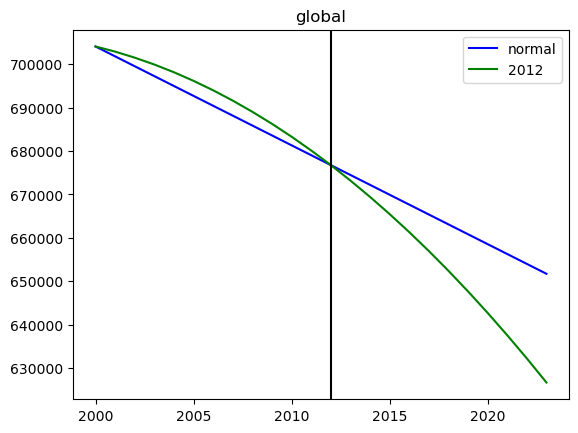

23    113.993
Name: glacier_area, dtype: float64


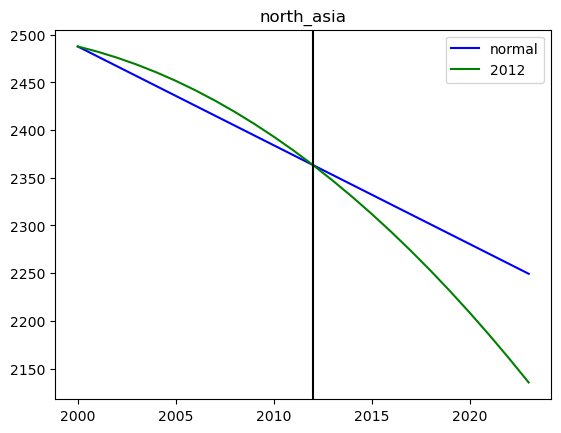

23    214.0116
Name: glacier_area, dtype: float64


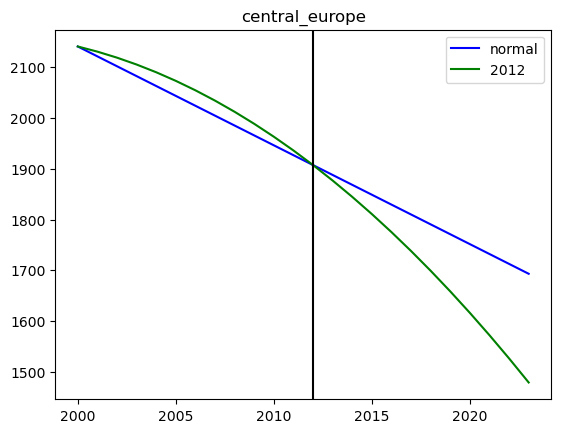

23    76.1981
Name: glacier_area, dtype: float64


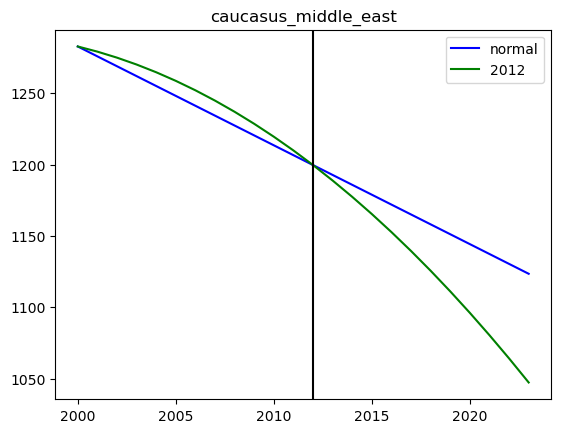

23    976.1994
Name: glacier_area, dtype: float64


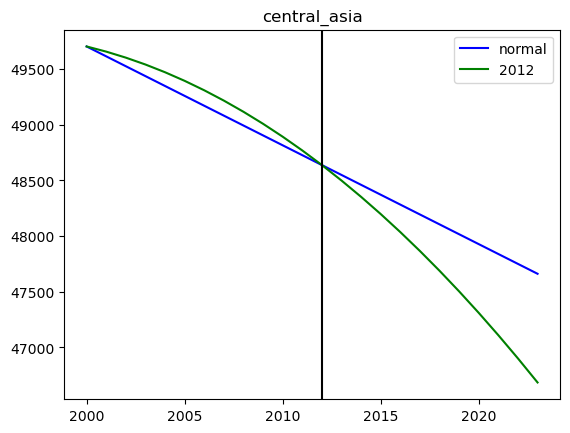

23    1329.2928
Name: glacier_area, dtype: float64


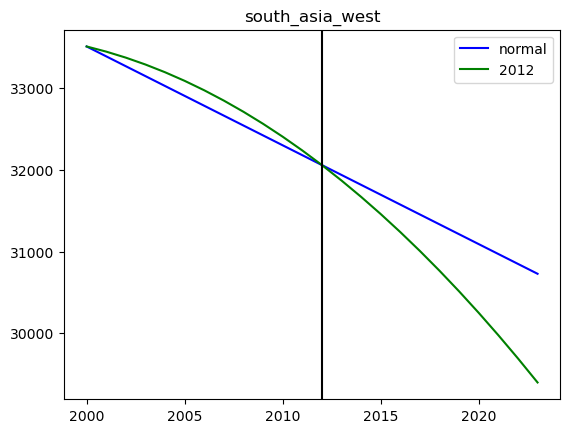

23    761.7478
Name: glacier_area, dtype: float64


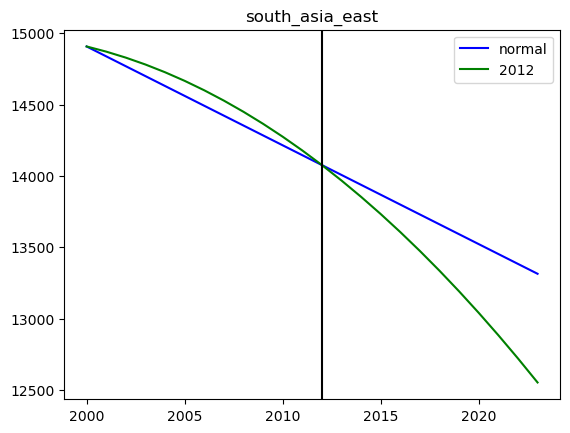

23    306.4369
Name: glacier_area, dtype: float64


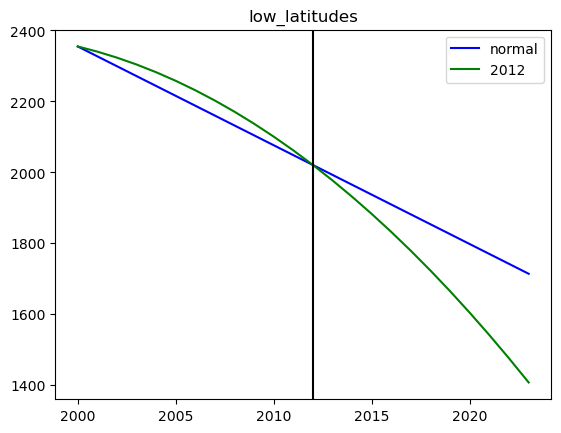

23    582.6942
Name: glacier_area, dtype: float64


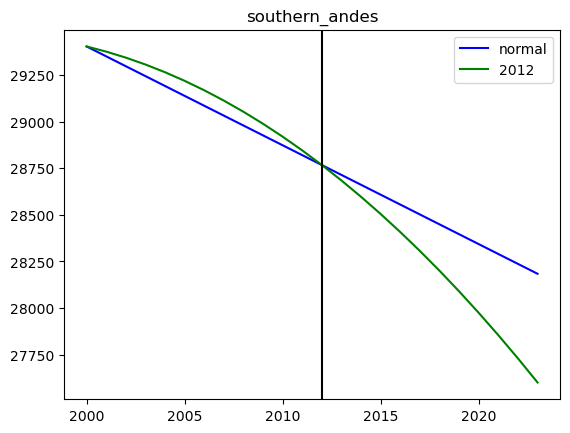

23    88.1958
Name: glacier_area, dtype: float64


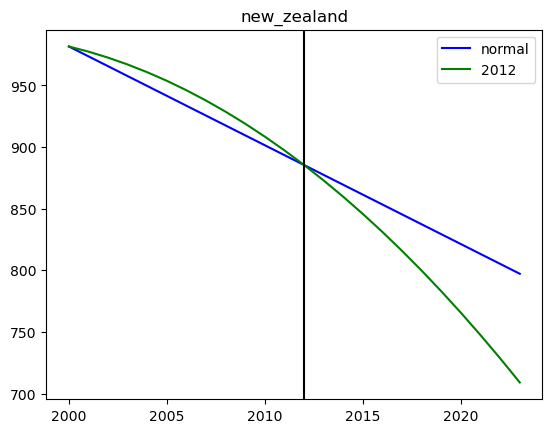

23    3946.1499
Name: glacier_area, dtype: float64


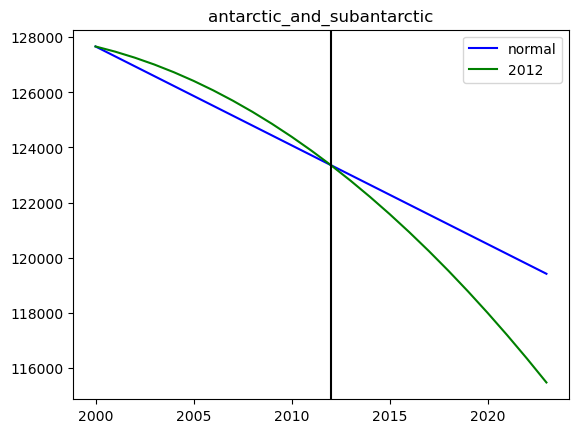

23    4579.08
Name: glacier_area, dtype: float64


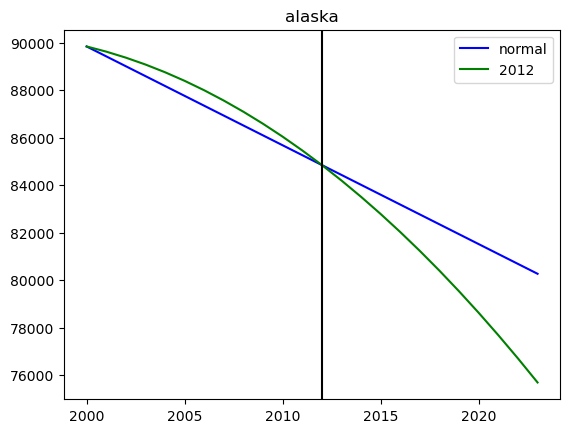

23    862.7256
Name: glacier_area, dtype: float64


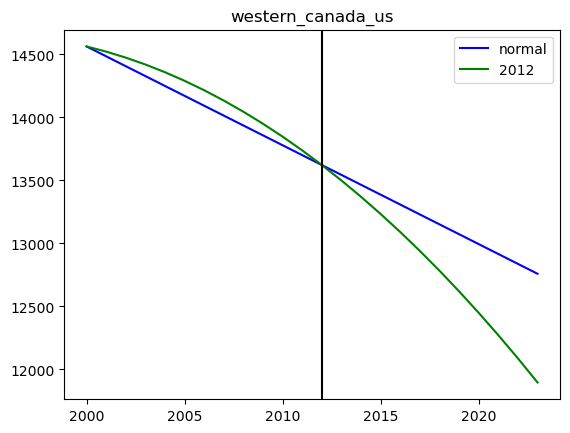

23    809.3547
Name: glacier_area, dtype: float64


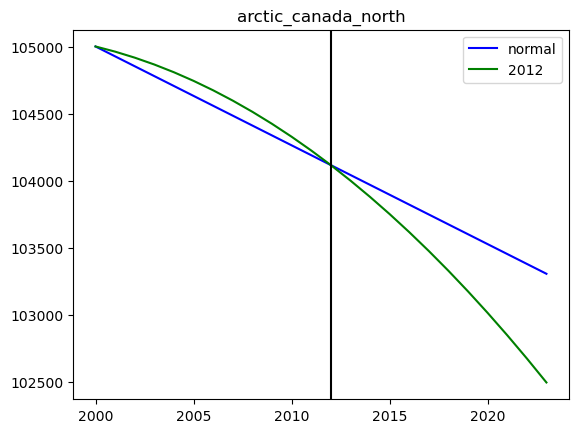

23    359.8144
Name: glacier_area, dtype: float64


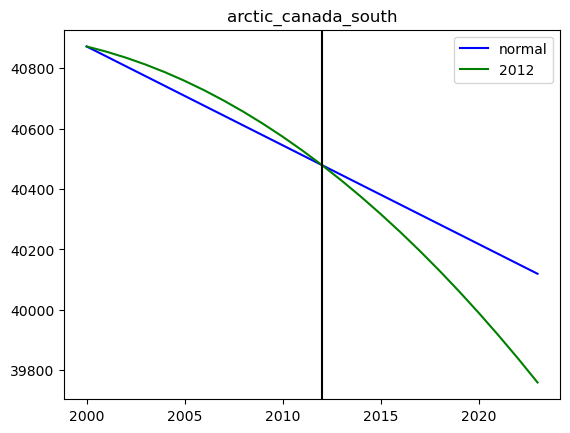

23    8092.4734
Name: glacier_area, dtype: float64


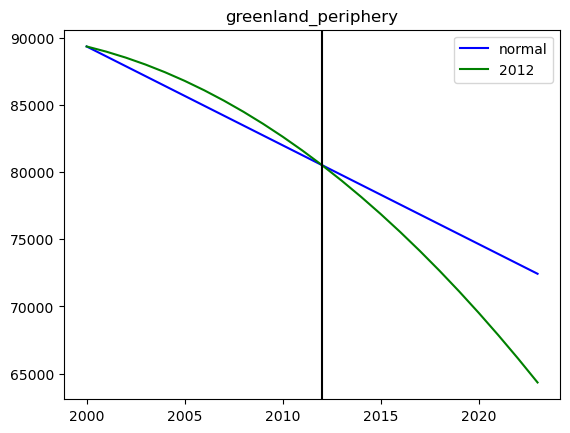

23    437.976
Name: glacier_area, dtype: float64


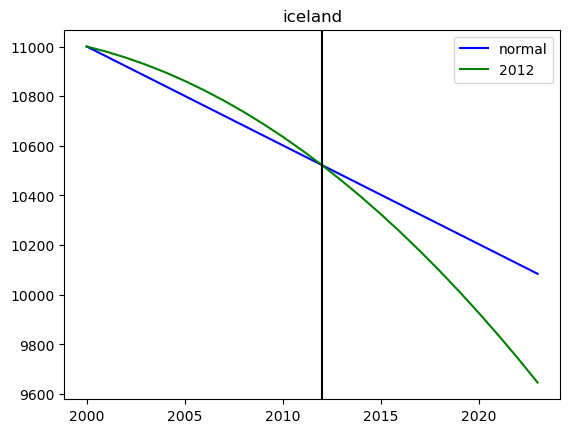

23    971.2274
Name: glacier_area, dtype: float64


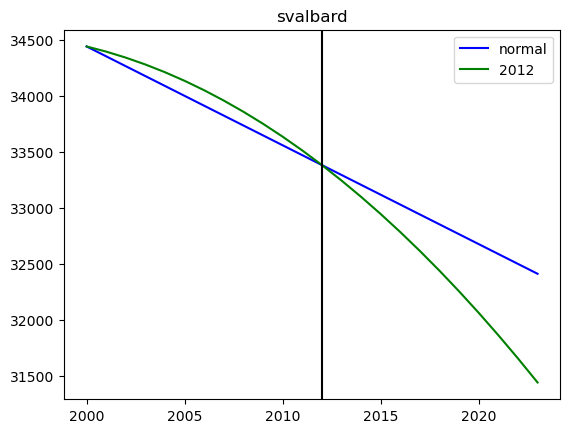

23    87.5853
Name: glacier_area, dtype: float64


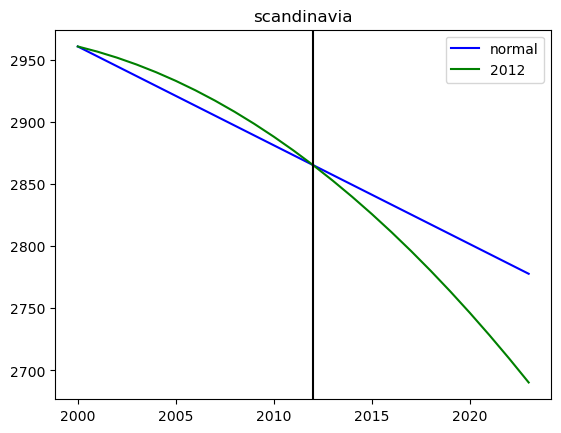

23    454.0096
Name: glacier_area, dtype: float64


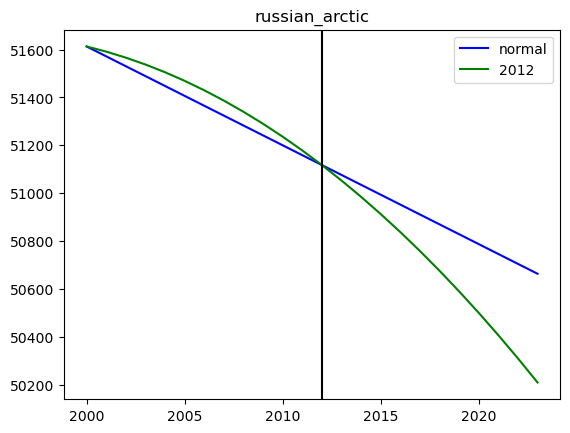

In [109]:
for i in range(0,len(list_of_folders)):
    #define region name and path to results
    region = list_of_folders[i]
    
    #get the region name without  the number
    region_name = region[region.find("_")+1:-4]
    #print(region_name)

    #read in the data
    region_old = pd.read_csv(os.path.join(d_dir_old, region)).drop('Unnamed: 0', axis=1)
    #region_2023 = pd.read_csv(os.path.join(d_dir_2023, region)).drop('Unnamed: 0', axis=1)
    region_2024 = pd.read_csv(os.path.join(d_dir_2024, region)).drop('Unnamed: 0', axis=1)
    

    
    print(region_old.glacier_area[-1:] - region_2024.glacier_area[-1:])
    plt.plot(region_old.start_dates, region_old.glacier_area, color='blue', label='normal' )
    plt.plot(region_2024.start_dates, region_2024.glacier_area, color='green', label='2012')
    plt.axvline(x= 2012, color='black' ) #50% point
    
    #plt.plot(region_2023.start_dates, region_2023.glacier_area, color='orange', label='2023')
    #plt.plot(region_2024.start_dates, region_2024.area_half, color='red', label='2012')

    plt.title(region_name)
    plt.legend()
    plt.show()

    